In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from scipy.spatial import distance
import cv2
import matplotlib.patheffects as pe
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/Users/junwoopark/Downloads/python/SPT_a/andi_datasets/utils_videos.py:22: UserWarning: From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.
  warnings.warn('From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.')


In [2]:
model_num = 24

In [3]:
N = 10
T = 500
L = None

WINDOW_WIDTHS = np.arange(100, 150, 2)
SHIFT_WIDTH = 40
JUMP_D = 2

In [4]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [5]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[1: int(len(xs)/2)+1] - float(xs[1: int(len(xs)/2)+1][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[1: int(len(ys)/2)+1] - float(ys[1: int(len(ys)/2)+1][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])
            
            
            
            #xs1 = uncumulate(xs1)
            #xs2 = uncumulate(xs2)
            #ys1 = uncumulate(ys1)
            #ys2 = uncumulate(ys2)

            

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = abs(np.cumsum(abs(xs1))) #* surface_xs1
            xs2 = abs(np.cumsum(abs(xs2))) #* surface_xs2
            ys1 = abs(np.cumsum(abs(ys1))) #* surface_ys1
            ys2 = abs(np.cumsum(abs(ys2))) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            #xs1 = xs1 / win_width
            #xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            #ys1 = ys1 / win_width 
            #ys2 = ys2 / win_width
            
            """
            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))
            """
            vals.append((abs(xs1[-1] - xs2[-1] + ys1[-1] - ys2[-1]))) 
                    #* (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                     #        * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)

    all_vals = np.array(all_vals) + 1e-7
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [6]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [7]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        if i <= ext_width + shift_width//2:
            crop = np.hstack((np.ones((signal_seq.shape[0], shift_width - crop.shape[1])) * np.mean(crop[:,0]), crop))
        elif i >= ext_width + signal_seq.shape[1] - shift_width//2:
            crop = np.hstack((crop, np.ones((signal_seq.shape[0], shift_width - crop.shape[1])) * np.mean(crop[:,-1]) ))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [8]:
def merge_close_points(changepoints, signal, pred_probas, seuil=5):
    seq_sums = []
    val_orders = np.argsort(np.sum(signal[:, changepoints], axis=0))[::-1]
    #val_orders = np.argsort(pred_probas)[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [9]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(signal.shape[1], ext_width), shift_width)

    return (signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
            norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

In [10]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [11]:
def press_cp(cps, jump_d):
    filtered_cps = []
    if len(cps) == 0:
        return []
    if len(cps) == 1:
        return cps
    
    for i in range(len(cps)):
        if i == 0:
            if cps[i] + jump_d == cps[i+1]:
                filtered_cps.append(cps[i])
        elif i == len(cps) - 1:
            if cps[i] - jump_d == cps[i-1]:
                filtered_cps.append(cps[i])
        else:
            if cps[i] == cps[i-1] + jump_d or cps[i] == cps[i+1] - jump_d:
                filtered_cps.append(cps[i])
    return np.array(filtered_cps)
    

In [12]:
def slice_sum_divide(slices, jump_d, shift_width):
    slice_d = []
    for i in range(0, slices.shape[0], jump_d):
        crop = slices[i - shift_width//2: i + shift_width//2]
        if i <= shift_width//2:
            crop = np.hstack((np.zeros((shift_width - crop.shape[0])), crop))
        elif i >= slices.shape[0] - shift_width//2:
            crop = np.hstack((crop, np.zeros((shift_width - crop.shape[0]))))
        slice_d.append(crop)
    return np.array(slice_d)

In [13]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    cps_before_reg = []
    if x.shape[0] <  win_widths[0]:
        return cps
    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1]//2,
                                                                                       jump_d,
                                                                                      SHIFT_WIDTH)
    #signal, norm_signal = make_signal(x, y, win_widths)
    #input_signals, indice = slice_data(signal, jump_d=jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        pred_org = pred.copy()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.5]
        cps_before_reg = cps.copy()

        if check_proba:
            for k, i in enumerate(range(0, x.shape[0], jump_d)):
                print(np.round(pred[k], 3), i, end='     ')
            print()
            

    if len(cps) == 0:
        return cps, cps_before_reg, np.round(pred_org, 3)

    reg_inputs = input_signals[cps//jump_d,:,:,:]
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()

    if check_proba:
        print(np.hstack((cps, reg_outputs)).reshape(-1, 2))
    
    app_indice = np.argwhere(abs(reg_outputs) < jump_d*2).flatten()
    cps = cps[app_indice]
    reg_outputs = reg_outputs[app_indice]
    cps = np.round(cps + reg_outputs).astype(int)

    input_signals = []
    indices = []
    cps_doublecheck = []

    for cp_check in cps:
        if cp_check <= 0 or cp_check >= x.shape[0]:
            continue
        indices.append(cp_check)
        input_signals.append(ext_signal[:, min(x.shape[0], win_widths[-1]//2) + cp_check - SHIFT_WIDTH//2:
                              min(x.shape[0], win_widths[-1]//2) + cp_check + SHIFT_WIDTH//2])

    if len(indices) == 0:
        return [], np.sort(cps_before_reg), np.round(pred_org, 3)
        
    input_signals = np.array(input_signals)
    input_signals = input_signals.reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps_doublecheck = np.array(indices)[np.argwhere(pred >= 0.5).flatten()]
        pred_probas = pred[np.argwhere(pred >= 0.5).flatten()]
        
    if len(cps_doublecheck) > 0:
        cps_doublecheck = merge_close_points(np.array(cps_doublecheck), signal, pred_probas, seuil=3)
    return np.sort(cps_doublecheck), np.sort(cps_before_reg), np.round(pred_org, 3)

In [14]:
classification_model = tf.keras.models.load_model(f'./models/{model_num}/cls_model_{SHIFT_WIDTH}_2.keras')
regression_model = tf.keras.models.load_model(f'./models/{model_num}/reg_model_{SHIFT_WIDTH}_2.keras')

OSError: No file or directory found at ./models/24/cls_model_40_2.keras

In [14]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 0
fovs = [6]
traj_idx = [9] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
checkpoints = [0]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        print('Trajectory legnth: ', x.shape)
        # Assign one changepoints for each traj at 0.25 of its length

        cps,pred_p = ana_cp_predict2(classification_model,
                                      x,
                                      y,
                                      WINDOW_WIDTHS,
                                      JUMP_D,
                                      SHIFT_WIDTH,
                                      True)
        #cps_before_reg = np.setdiff1d(cps_before_reg, [x for x in np.concatenate((np.arange(3), np.arange(length_traj-3, length_traj)))])
        #print(cps_before_reg)
        
        print(f'CPS: {cps}')
        
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y, 
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  JUMP_D,
                                                                                  SHIFT_WIDTH)
        
        plt.figure(figsize=(8, 8))
        plt.plot(x, y, linewidth=0.8)
        plt.xlim([np.min(x) - 25,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        plt.ylim([np.min(y) - 25,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        for checkpoint in checkpoints:
            plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')
        
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')
        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
        for cp in cps:
            ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], c='red', alpha=0.6)

        ax.set_xlim([np.min(x) - 10,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.set_ylim([np.min(y) - 10,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
        ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
        for checkpoint in checkpoints:
            ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

        plt.figure()
        for i in range(signals.shape[0]):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.2,
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])
        plt.scatter(cps, np.array([np.max(signals) + 1] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(signals)] * len(cps_before_reg)), c='red')
        plt.ylim([0, max(10, np.max(signals)) + 2])
        
        plt.figure()
        for i in range(norm_signals.shape[0]):
            plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.2, 
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
        comp_signal = compress_signals(norm_signals)
        #plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')
        #plt.plot(np.arange(signals.shape[1]), comp_signal, c='black')
        plt.scatter(cps, np.array([np.max(comp_signal) + 0.2] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(comp_signal) + 0.1] * len(cps_before_reg)), c='red')
        plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')
        
        
        
        
 
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  10)
        cps = press_cp(cps, JUMP_D)
        slice_sum = np.sum(sliced_signals, axis=(1, 2))

        slice_sum /= np.max(slice_sum)
        plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
        print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
        print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
        merged_cps = list(map(climb_mountain,
                              [slice_sum] * len(cps),
                              cps,
                             [5 * JUMP_D ] * len(cps)))
        merged_cps = np.sort(np.unique(merged_cps))
        if -1 in merged_cps:
            merged_cps = np.delete(merged_cps, 0)
        plt.scatter(merged_cps, np.array([np.max(slice_sum) + 0.2] * len(merged_cps)), c='black')
        for idx, mer_cp in enumerate(merged_cps):
            merged_cps[idx] = cps[np.argmin(abs(cp - float(mer_cp)))]

        
        reg_inputs = []
        for merged_cp in merged_cps:
            xx = signals[:, max(0, -SHIFT_WIDTH//2 + merged_cp) : min(signals.shape[1], SHIFT_WIDTH//2 + merged_cp)]
            if merged_cp < SHIFT_WIDTH//2:
                xx = np.hstack((np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1])), xx))
            elif merged_cp > signals.shape[1] - SHIFT_WIDTH//2:
                xx = np.hstack((xx, np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1]))))             
            reg_inputs.append(xx)
        reg_inputs = np.array(reg_inputs).reshape(-1, signals.shape[0], SHIFT_WIDTH, 1)
        if reg_inputs.shape[0] != 0:
            reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
            final_cps = np.round(merged_cps + reg_outputs).astype(int)
            final_cps = merge_close_points(final_cps, signals, None, seuil=3)
            plt.scatter(final_cps, np.array([np.max(slice_sum) + 0.25] * len(final_cps)), c='orange')
            for aa in final_cps:
                ax.scatter3D(x[aa], y[aa], np.arange(signals.shape[1])[aa], marker='+', c='blue', alpha=0.7)

        

    

Trajectory legnth:  (128,)


NameError: name 'ana_cp_predict2' is not defined

NameError: name 'classification_model' is not defined

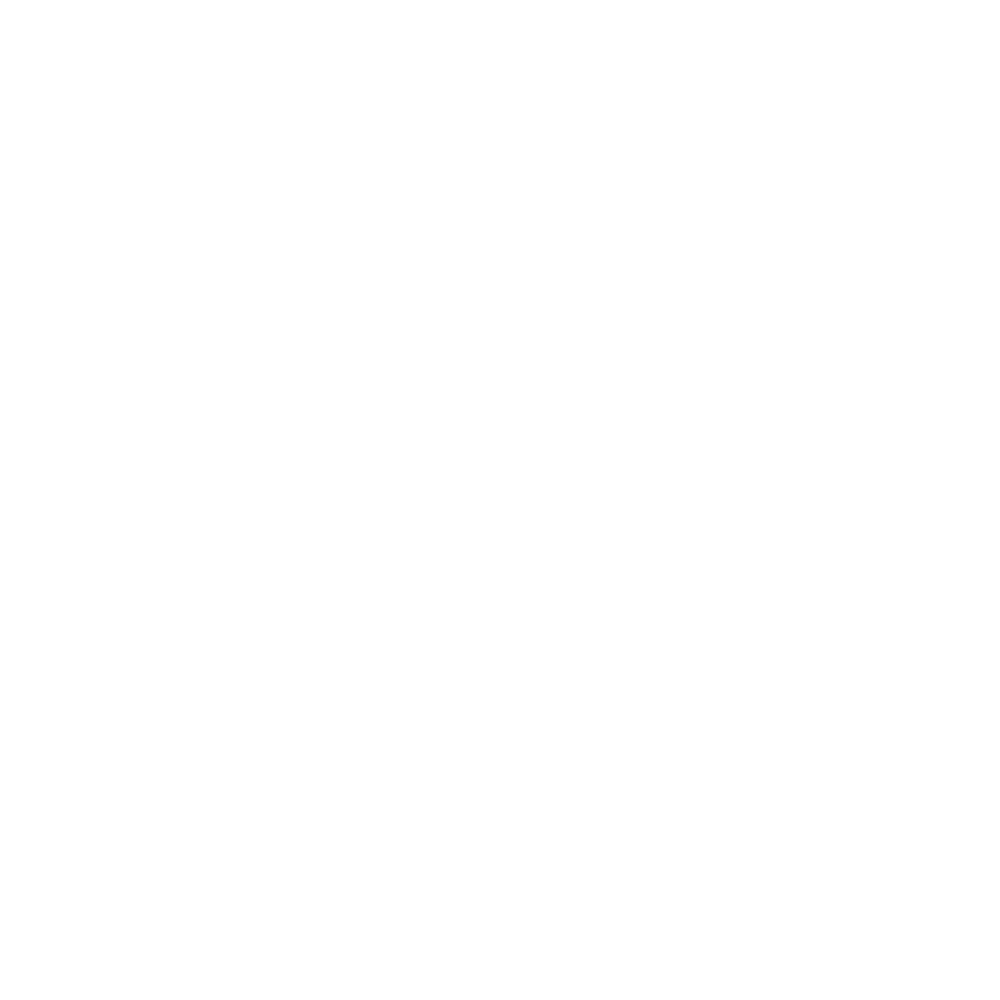

In [16]:
track = 2
exp = 12
fovs = [0]
check_indice = [0, 10]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
    plt.figure(figsize=(10, 10))
    for idx in np.unique(df.traj_idx).astype(int)[check_indice[0]: check_indice[1]]:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        cps, _ = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)

        trajectory = plt.plot(x, y, linewidth=0.8, zorder=0)
        plt.scatter(x[0], y[0], marker='>', c='red', zorder=1, alpha=0.7)
        plt.annotate(str(idx), xy=(x[0]-1,y[0]-2), color=trajectory[0].get_color(), path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.scatter(x[-1], y[-1], marker='<', c='blue', zorder=1, alpha=0.7)
        for cp in cps:
            plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2) 


# Produce a trajectory and check signals

In [ ]:
def ana_cp_predict2(model, x, y, win_widths, jump_d, shift_width, check_proba=False):
    cps = []
    if x.shape[0] < win_widths[0]:
        return cps

    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1] // 2,
                                                                                       jump_d,
                                                                                       shift_width)

    _, _, sliced_signals, _, _ = signal_from_extended_data(x, y,
                                                           win_widths,
                                                           win_widths[-1] // 2,
                                                           1,
                                                           10)

    slice_sum = np.sum(sliced_signals, axis=(1, 2))
    slice_sum /= np.max(slice_sum)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1) ** 2 / np.std(signal, axis=1) ** 2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    input_slice_sum = slice_sum_divide(slice_sum, jump_d, shift_width).reshape(-1, 1, SHIFT_WIDTH, 1)
    input_slice_snr = np.array([np.mean(slice_sum)**2 / np.std(slice_sum)**2] * input_slice_sum.shape[0])


    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1, input_slice_sum, input_slice_snr], verbose=0).flatten()
        cps = indice[pred >= 0.5]

    cps = press_cp(cps, jump_d)
    if len(cps) == 0:
        return cps, pred



    merged_cps = list(map(climb_mountain,
                          [slice_sum] * len(cps),
                          cps,
                          [5 * jump_d] * len(cps)))
    merged_cps = np.sort(np.unique(merged_cps))
    if -1 in merged_cps:
        merged_cps = np.delete(merged_cps, 0)
    for idx, mer_cp in enumerate(merged_cps):
        merged_cps[idx] = cps[np.argmin(abs(cps - float(mer_cp)))]

    reg_inputs = []
    for merged_cp in merged_cps:
        xx = signal[:, max(0, -shift_width//2 + merged_cp) : min(signal.shape[1], shift_width//2 + merged_cp)]
        if merged_cp < shift_width//2:
            xx = np.hstack((np.zeros((xx.shape[0], shift_width - xx.shape[1])), xx))
        elif merged_cp > signal.shape[1] - shift_width//2:
            xx = np.hstack((xx, np.zeros((xx.shape[0], shift_width - xx.shape[1]))))
        reg_inputs.append(xx)
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], shift_width, 1)

    if len(merged_cps) != 0:
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        final_cps = np.round(merged_cps + reg_outputs).astype(int)
        final_cps = merge_close_points(final_cps, signal, None, seuil=3)
        return np.sort(final_cps), pred
    else:
        return [], pred

In [223]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=200,
                                                        alphas=[0.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[1.0, 0.0], [0.0, 1.0]]
                                                       )

In [ ]:
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
cps,pred_p = ana_cp_predict2(classification_model,
                              trajs_model[:, 0, 0],
                              trajs_model[:, 0, 1],
                              WINDOW_WIDTHS,
                              JUMP_D,
                              SHIFT_WIDTH,
                              True)

changepoints = changepoints[:-1]
print(f'GT: {changepoints}')
print(f'Pred: {cps}')

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals, _ , _ , _ = signal_from_extended_data(x, y,
                                                             WINDOW_WIDTHS,
                                                             WINDOW_WIDTHS[-1]//2,
                                                             JUMP_D,
                                                             SHIFT_WIDTH)
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in cps:
    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in cps:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='red', zorder=2)
for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)

plt.figure()
plt.ylim([0, max(10, np.max(signals)) + 2])
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='blue')

for cp in cps:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='red')

        
plt.figure()
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

for cp in cps:
    plt.vlines(cp, 0, 1, color='red')

plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')


signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  5)

slice_sum = np.sum(sliced_signals, axis=(1, 2))
slice_sum -= np.min(slice_sum)
slice_sum /= np.max(slice_sum)

plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
print(f'slice_sum_SNR: {1 / (np.mean(slice_sum)**2 * np.std(slice_sum)**2)}')

In [ ]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
track = 2
exp = 2
fovs = [17]
traj_idx = [3] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
changepoints = []

In [219]:
trajs_model, labels_model = models_phenom().single_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=1.5,
                                                        Ds=0.1,
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

In [106]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.5, 1.5],
                                                        Ds=[[0.05, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

In [107]:
def position_extension(x, y, ext_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
    return np.array(datas), delta_prev_data.shape[0], delta_next_data.shape[0]
    

In [108]:
def density_estimation(x, y, ext1, ext2, max_nb=10):
    densities = []
    dist_amp = 2.
    for i in range(ext1, x.shape[0] - ext2):
        density1 = 0
        slice_x = x[i-max_nb//2:i].copy()
        slice_y = y[i-max_nb//2:i].copy()
        mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
        mean_dist *= dist_amp
        slice_x -= slice_x[len(slice_x)//2]
        slice_y -= slice_y[len(slice_y)//2]
        for s_x, s_y in zip(slice_x, slice_y):
            if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                density1 += 1
    

        density2 = 0
        slice_x = x[i:i+max_nb//2].copy()
        slice_y = y[i:i+max_nb//2].copy()
        mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
        mean_dist *= dist_amp
        slice_x -= slice_x[len(slice_x)//2]
        slice_y -= slice_y[len(slice_y)//2]
        for s_x, s_y in zip(slice_x, slice_y):
            if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                density2 += 1
        densities.append(max(density1, density2))
        
    
    new_densities = []
    for i in range(len(densities)):
        new_densities.append(np.mean(densities[max(0, i-2): min(len(densities), i+3)]))
    densities = new_densities
        
    return np.array(densities)

In [109]:
def signal_from_extended_data2(x, y, win_widths, ext_width, jump_d, shift_width):
    datas, shape_ext1, shape_ext2 = position_extension(x, y, ext_width)
    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    density = density_estimation(datas[0], datas[1], shape_ext1, shape_ext2, max_nb=40)
    

    pp = signal[:, shape_ext1:signal.shape[1]-shape_ext2] * density
    signal[:, shape_ext1:signal.shape[1]-shape_ext2] = pp
    
    sliced_signals, slice_indice = slice_data(signal, jump_d,
                                              min(x.shape[0], shape_ext1), shift_width)
    
    return (signal[:, shape_ext1:signal.shape[1] - shape_ext2],
            norm_signal[:, shape_ext1:signal.shape[1] - shape_ext2],
           sliced_signals,
           slice_indice,
           signal,
           density)

In [110]:
def local_roughness(signal, window_size):
    uc_signal = uncumulate(signal)
    uc_signal /= abs(uc_signal)
    counts = []
    for i in range(window_size//2, len(uc_signal) - window_size//2):
        count = 0
        cur_state = 1
        for j in range(i-window_size//2, i+window_size//2):
            new_state = uc_signal[j]
            if new_state != cur_state:
                count += 1
            cur_state = new_state
        counts.append(count)
    counts = np.concatenate(([counts[0]] * (window_size//2), counts))
    counts = np.concatenate((counts, [counts[-1]] * (window_size//2)))
    return counts

GT: [237 375 383 456 491]


/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_2863/1408332415.py:3: RuntimeWarning: invalid value encountered in divide
  uc_signal /= abs(uc_signal)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(30, 500)
(15, 500)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


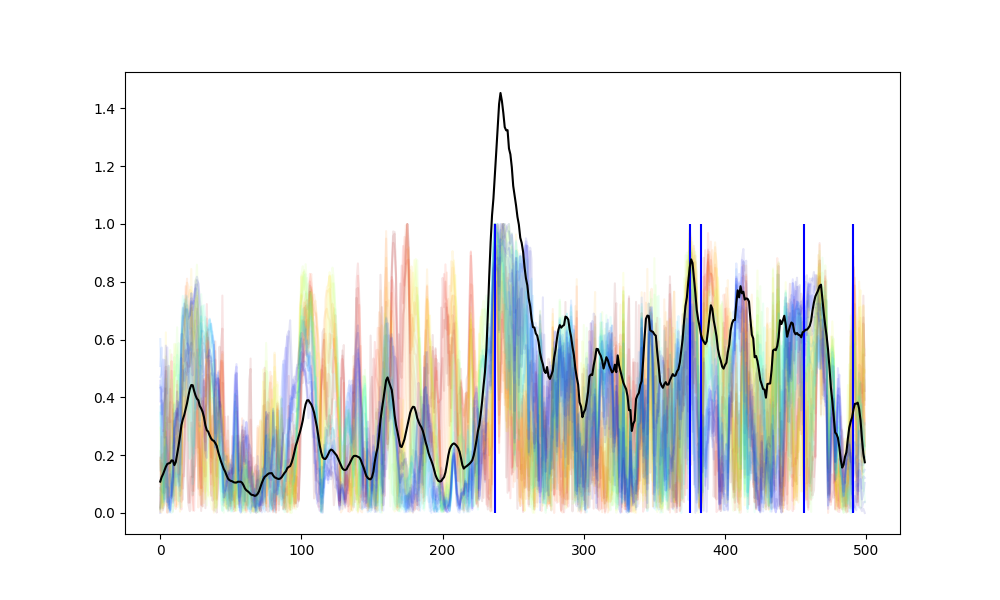

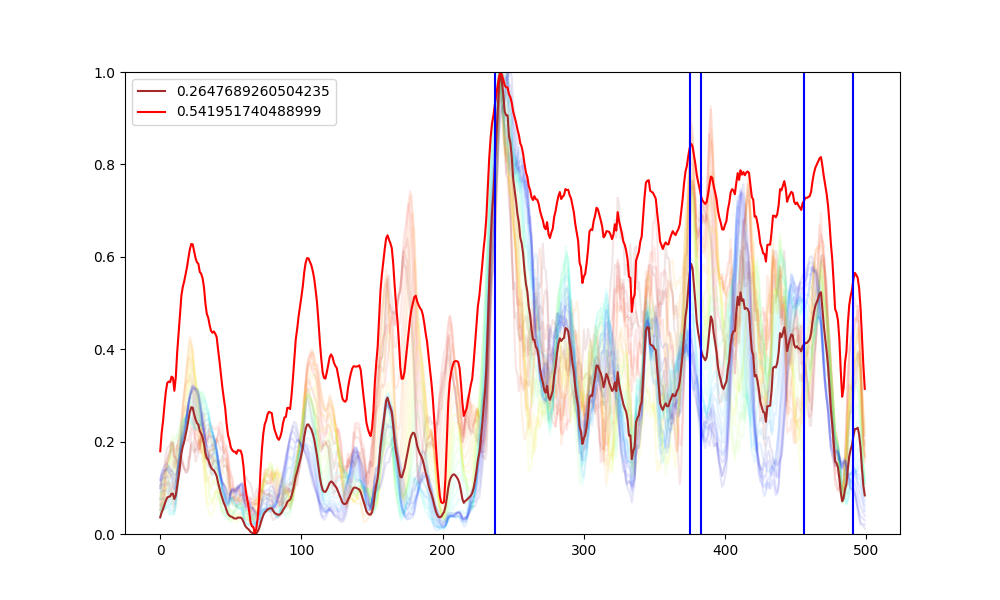

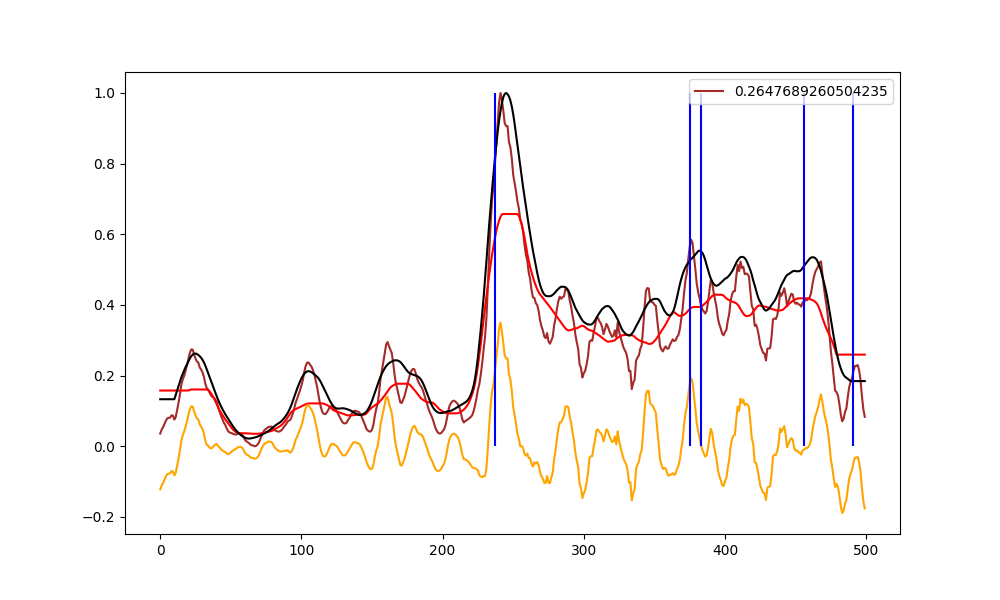

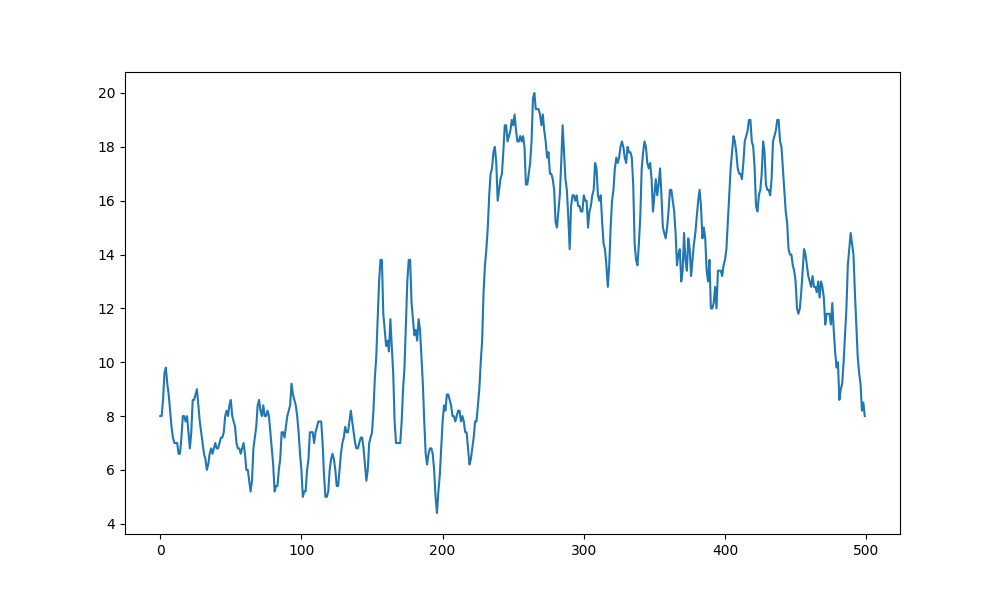

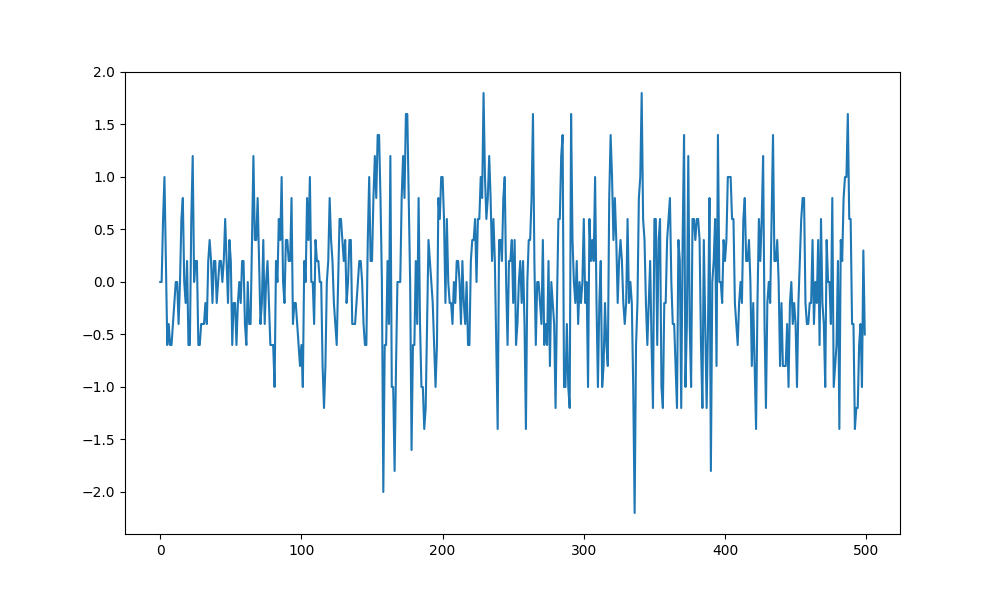

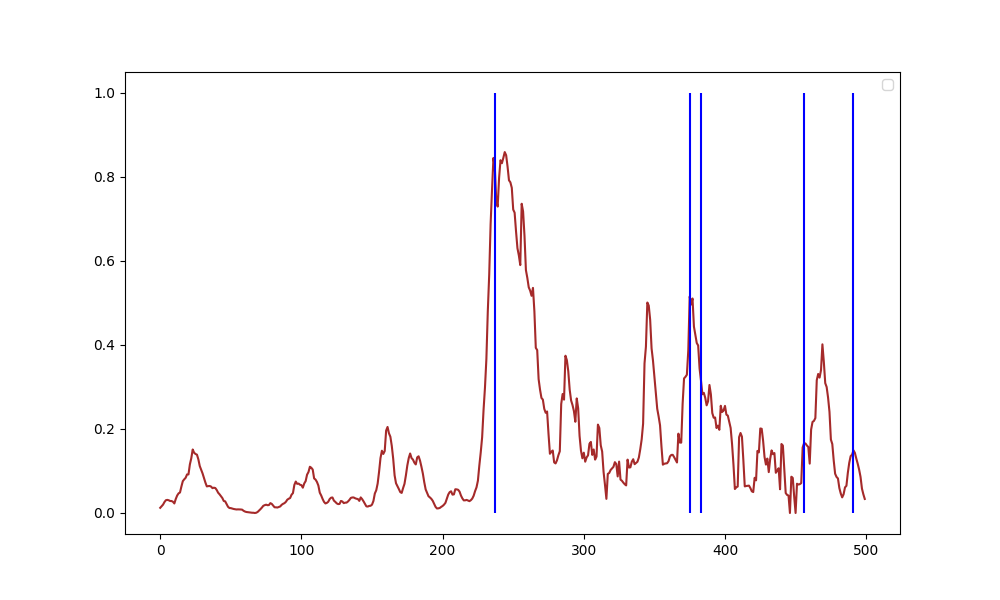

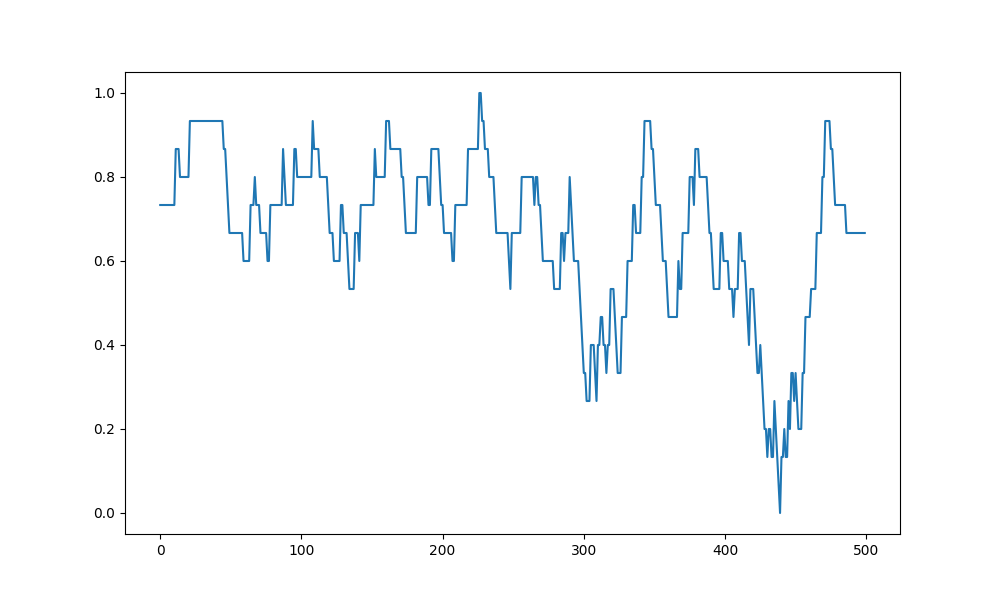

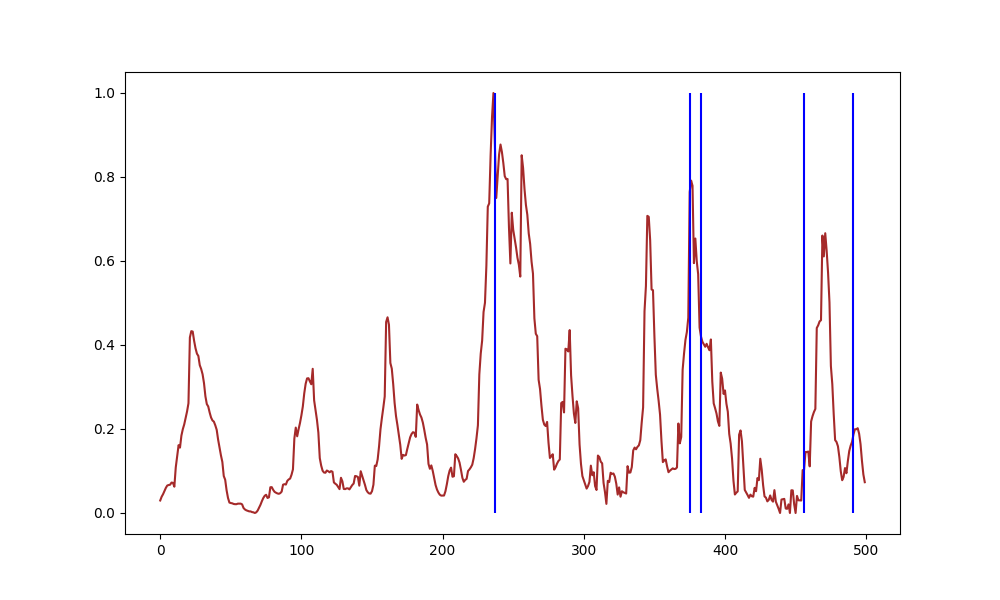

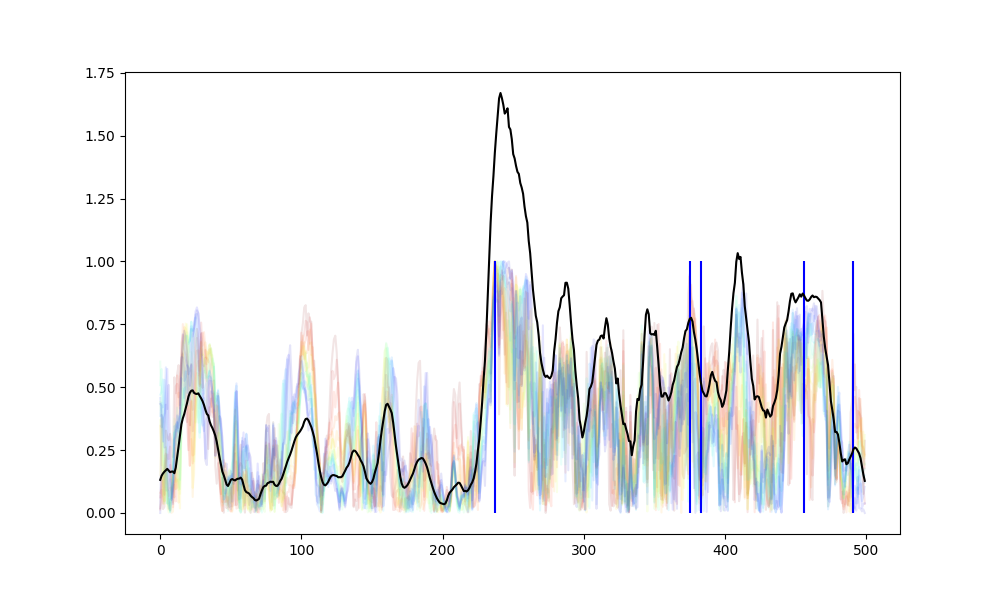

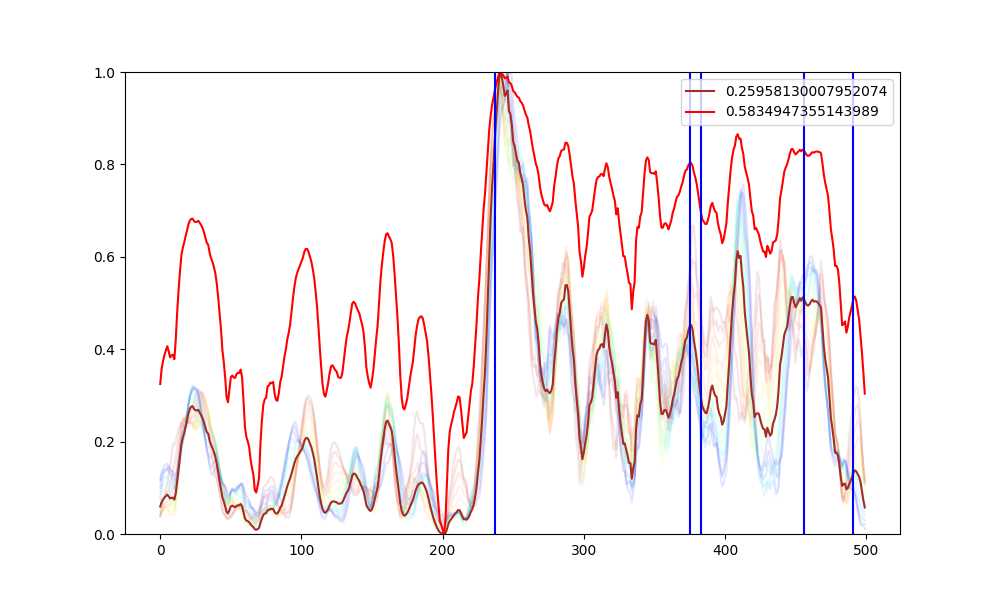

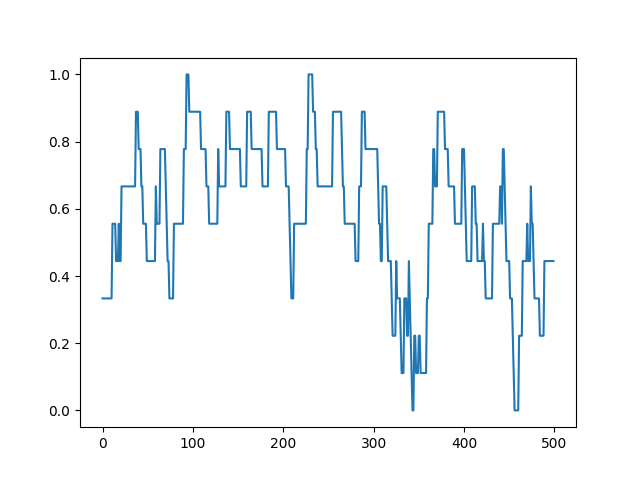

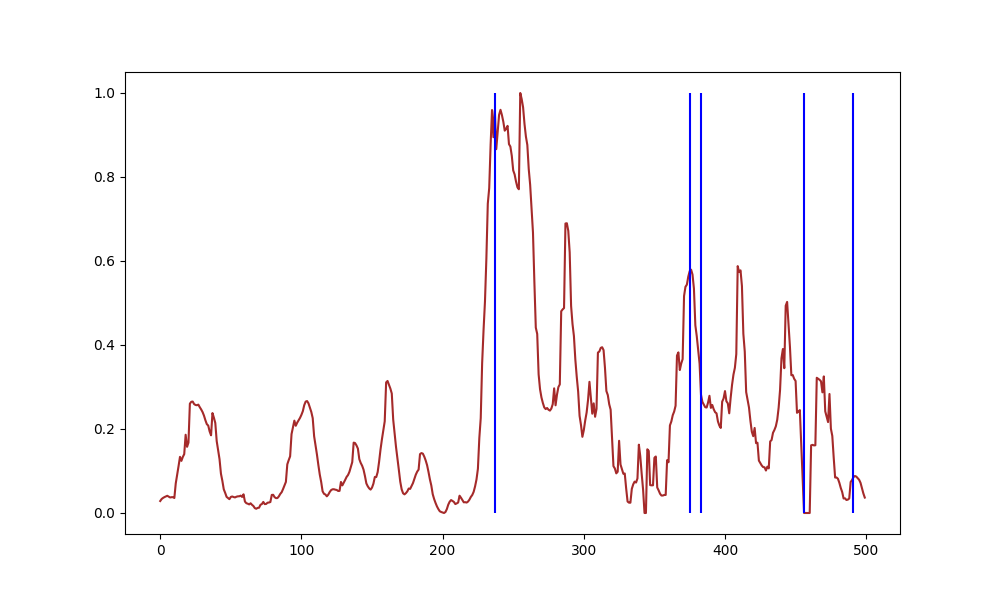

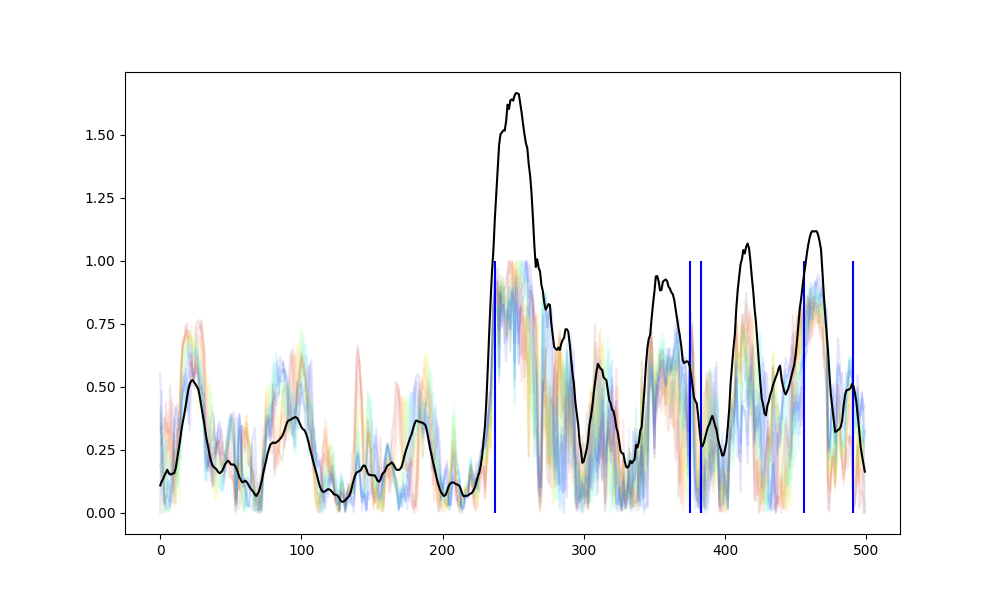

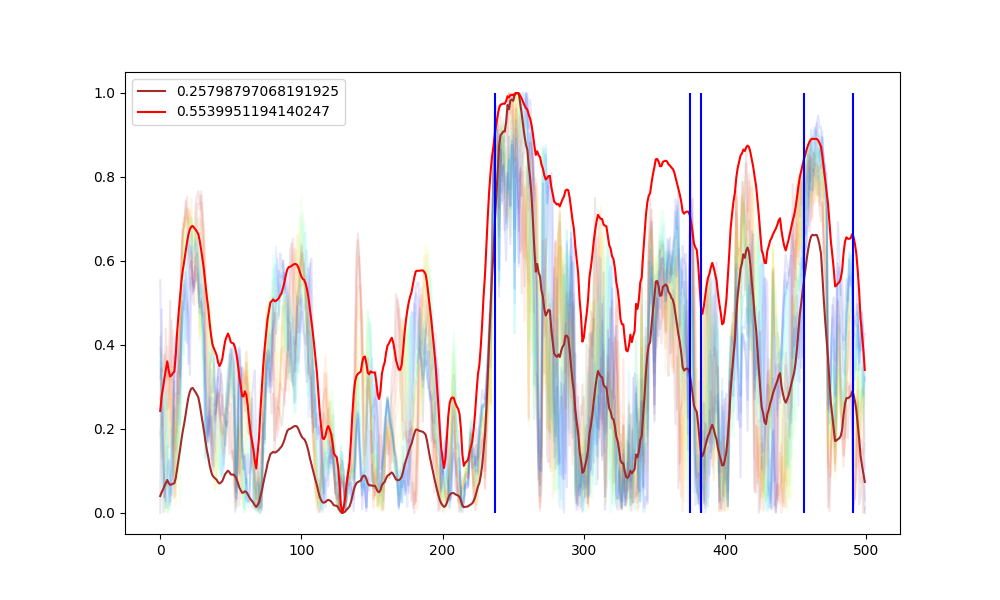

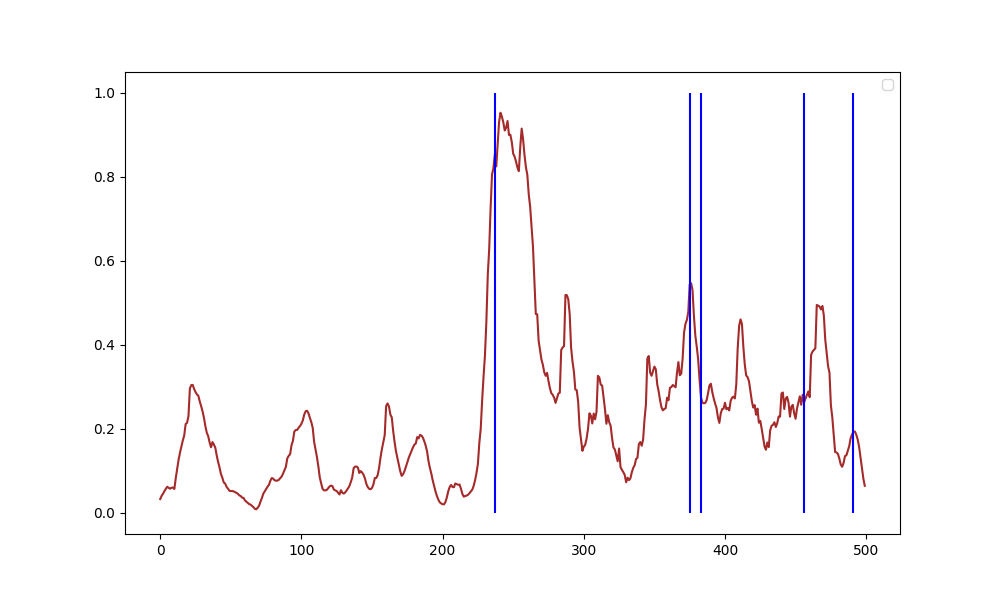

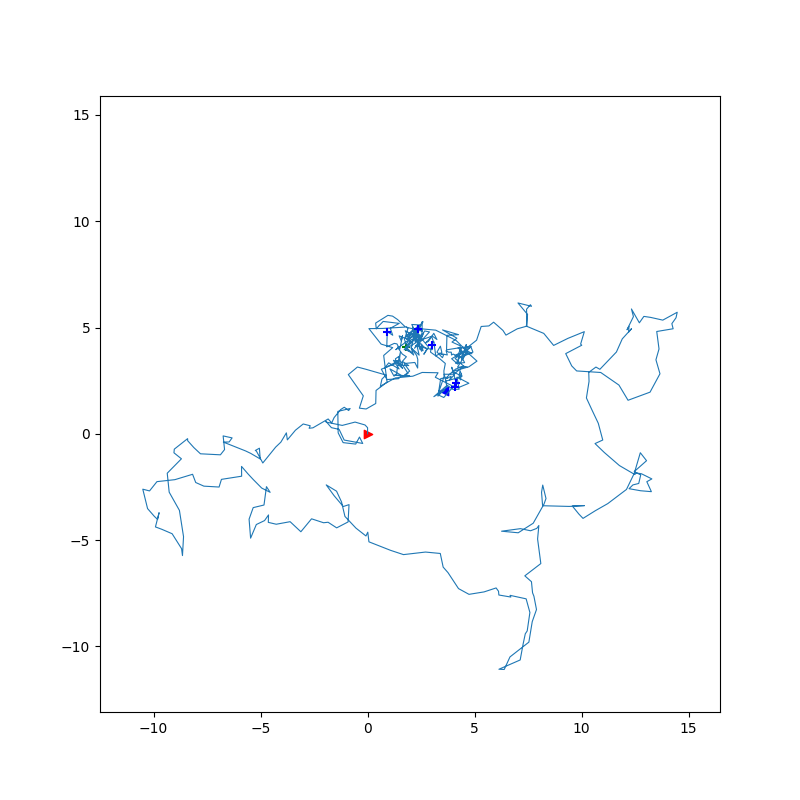

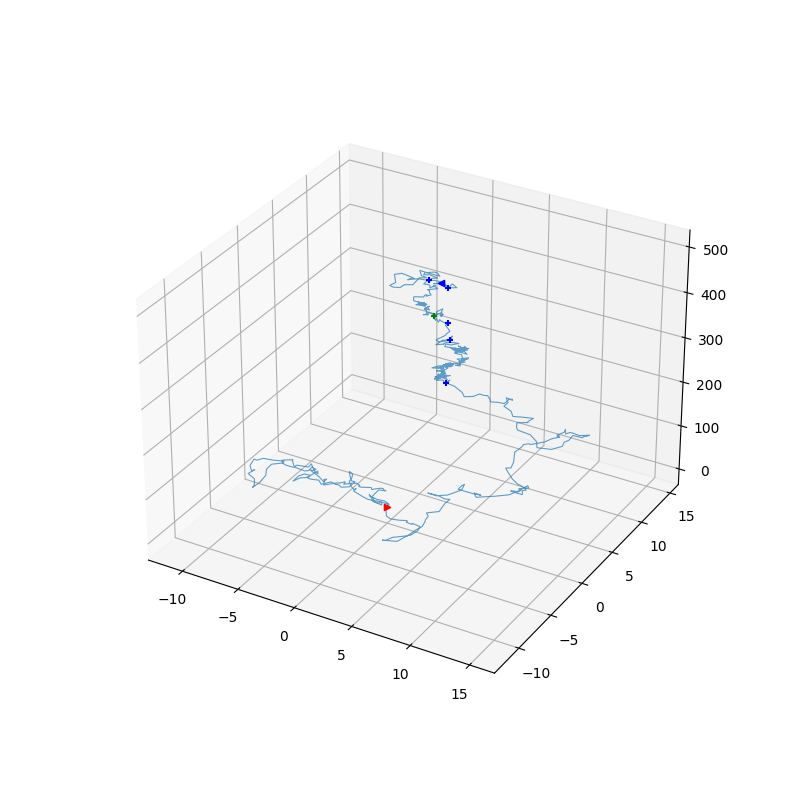

In [111]:
print(f'GT: {changepoints}')
win_widths1 = np.arange(20, 80, 2)
win_widths2 = np.arange(50, 80, 2)
win_widths3 = np.arange(80, 110, 2)

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
checkpoints = [392]

signals, norm_signals, slice_sig , _ , _, density = signal_from_extended_data2(x, y,
                                                             win_widths1,
                                                             win_widths1[-1]//2,
                                                             1,
                                                            10)

plt.figure(figsize=(10, 6))
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

plt.plot(np.arange(0, signals.shape[1]), np.sum(slice_sig, axis=(1,2)) / np.sum(norm_signals) , c='black')
plt.figure(figsize=(10, 6))
for i in range(len(win_widths1)):
    plt.plot(np.arange(0, signals.shape[1]), (np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1))[i]/
             np.max((np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1))[i]),
             c=color_seq[int(i * 255 / norm_signals.shape[0])], alpha=0.1)

print(signals.shape)
val1 = np.mean(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0)
val1 = val1 - np.min(val1)
val1 = val1 / np.max(val1)
val2 = np.log(np.prod(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0))
val2 = val2 - np.min(val2)
val2 = val2 / np.max(val2)
plt.plot(np.arange(norm_signals.shape[1]), val1, c='brown', label=f'{np.mean(val1)}')
plt.plot(np.arange(norm_signals.shape[1]), val2, c='red', label=f'{np.mean(val2)}')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])
plt.legend()



local_rough = -local_roughness(val1, 20)
local_rough -= np.min(local_rough)
local_rough = local_rough.astype(float)
local_rough /= np.max(local_rough)

aa_val1 = val1
aa = val1
aa = aa * local_rough / np.max(aa * local_rough)

#####################################################

plt.figure(figsize=(10, 6))
val1 = np.mean(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0)
val1 = val1 - np.min(val1)
val1 = val1 / np.max(val1)

local_mean = [np.mean(np.sort(val1[i-20:i+20])[10:30]) for i in np.arange(20, signals.shape[1] - 20)]
local_mean = np.concatenate(([local_mean[0]] * 20, local_mean))
local_mean = np.concatenate((local_mean, [local_mean[-1]] * 20))

local_sum = [np.sum(val1[i-10:i+10]) for i in np.arange(10, signals.shape[1] - 10)]
local_sum = np.concatenate(([local_sum[0]] * 10, local_sum))
local_sum = np.concatenate((local_sum, [local_sum[-1]] * 10))

plt.plot(np.arange(signals.shape[1]), val1, c='brown', label=f'{np.mean(val1)}')
plt.plot(np.arange(signals.shape[1]), local_mean, c='red')
plt.plot(np.arange(signals.shape[1]), val1 - local_mean, c='orange')
plt.plot(np.arange(signals.shape[1]), local_sum / np.max(local_sum), c='black')

for cp in changepoints:
    plt.vlines(cp, 0, np.max(val1), color='blue')
plt.legend()


#####################################################
plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), density)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), uncumulate(density))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), aa * density/np.max(density), c='brown')

for cp in changepoints:
    plt.vlines(cp, 0, np.max(val1), color='blue')
plt.legend()


local_rough = -local_roughness(aa, 20)
local_rough -= np.min(local_rough)
local_rough = local_rough.astype(float)
local_rough /= np.max(local_rough)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), local_rough)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), aa * local_rough / np.max(aa * local_rough), c='brown', label=f'{np.mean(val1)}')

for cp in changepoints:
    plt.vlines(cp, 0, np.max(val1), color='blue')


####################################################

signals, norm_signals, slice_sig , _ , _, density = signal_from_extended_data2(x, y,
                                                             win_widths2,
                                                             win_widths2[-1]//2,
                                                             1,
                                                            10)

plt.figure(figsize=(10, 6))
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

plt.plot(np.arange(0, signals.shape[1]), np.sum(slice_sig, axis=(1,2)) / np.sum(norm_signals) , c='black')
plt.figure(figsize=(10, 6))
for i in range(len(win_widths2)):
    plt.plot(np.arange(0, signals.shape[1]), (np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1))[i]/
             np.max((np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1))[i]),
             c=color_seq[int(i * 255 / norm_signals.shape[0])], alpha=0.1)

print(signals.shape)
val1 = np.mean(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0)
val1 = val1 - np.min(val1)
val1 = val1 / np.max(val1)
val2 = np.log(np.prod(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0))
val2 = val2 - np.min(val2)
val2 = val2 / np.max(val2)
plt.plot(np.arange(norm_signals.shape[1]), val1, c='brown', label=f'{np.mean(val1)}')
plt.plot(np.arange(norm_signals.shape[1]), val2, c='red', label=f'{np.mean(val2)}')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])
plt.legend()





local_rough = -local_roughness(val1, 20)
local_rough -= np.min(local_rough)
local_rough = local_rough.astype(float)
local_rough /= np.max(local_rough)

bb_val1 = val1
bb = val1
bb = bb * local_rough / np.max(bb * local_rough)
#####################################################

#####################################################


plt.figure()
plt.plot(np.arange(signals.shape[1]), local_rough)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(signals.shape[1]), bb, c='brown', label=f'{np.mean(val1)}')
for cp in changepoints:
    plt.vlines(cp, 0, np.max(val1), color='blue')


####################################################


####################################################

signals, norm_signals, slice_sig , _ , _, density = signal_from_extended_data2(x, y,
                                                             win_widths3,
                                                             max(20, win_widths3[-1]//2),
                                                             1,
                                                            10)

plt.figure(figsize=(10, 6))
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

plt.plot(np.arange(0, signals.shape[1]), np.sum(slice_sig, axis=(1,2)) / np.sum(norm_signals) , c='black')
plt.figure(figsize=(10, 6))
for i in range(len(win_widths3)):
    plt.plot(np.arange(0, signals.shape[1]), (norm_signals)[i],
             c=color_seq[int(i * 255 / norm_signals.shape[0])], alpha=0.1)

slice_sig += 1e-6
val1 = np.mean(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0)
val1 = val1 - np.min(val1)
val1 = val1 / np.max(val1)
val2 = np.log(np.prod(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0))
val2 = val2 - np.min(val2)
val2 = val2 / np.max(val2)
plt.plot(np.arange(norm_signals.shape[1]), val1, c='brown', label=f'{np.mean(val1)}')
plt.plot(np.arange(norm_signals.shape[1]), val2, c='red', label=f'{np.mean(val2)}')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
#plt.ylim([0, 1])
plt.legend()






cc_val1 =val1
cc = val1
#####################################################

plt.figure(figsize=(10, 6))
plt.plot(np.arange(norm_signals.shape[1]), (aa + bb + cc) / 3., c='brown')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.legend()



#####################################################


plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for checkpoint in checkpoints:
    plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for checkpoint in checkpoints:
    ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

In [57]:
def signal_comparison2(x_pos, y_pos, win_widths, ext_width, checkpoint1, checkpoint2):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        
        xs1 = x_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        ys1 = y_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        
        xs2 = x_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        ys2 = y_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        
        xs1_l = xs1[1: int(len(xs1)/2)+1] - float(xs1[1: int(len(xs1)/2)+1][0])
        xs1_r = xs1[int(len(xs1)/2):] - float(xs1[int(len(xs1)/2):][0])

        ys1_l = ys1[1: int(len(ys1)/2)+1] - float(ys1[1: int(len(ys1)/2)+1][0])
        ys1_r = ys1[int(len(ys1)/2):] - float(ys1[int(len(ys1)/2):][0])
        
        xs2_l = xs2[1: int(len(xs2)/2)+1] - float(xs2[1: int(len(xs2)/2)+1][0])
        xs2_r = xs2[int(len(xs2)/2):] - float(xs2[int(len(xs2)/2):][0])

        ys2_l = ys2[1: int(len(ys2)/2)+1] - float(ys2[1: int(len(ys2)/2)+1][0])
        ys2_r = ys2[int(len(ys2)/2):] - float(ys2[int(len(ys2)/2):][0])
        
        
        
        
        xs1_l = np.cumsum(abs(xs1_l))
        xs1_r = np.cumsum(abs(xs1_r))
        ys1_l = np.cumsum(abs(ys1_l))
        ys1_r = np.cumsum(abs(ys1_r))
        xs2_l = np.cumsum(abs(xs2_l))
        xs2_r = np.cumsum(abs(xs2_r))
        ys2_l = np.cumsum(abs(ys2_l))
        ys2_r = np.cumsum(abs(ys2_r))

        #xs1_l, xs1_r, ys1_l, ys1_r
        #xs2_l, xs2_r, ys2_l, ys2_r
        comb = [[[xs1_l, xs2_r], [ys1_l, ys2_r]], [[xs1_r, xs2_l], [ys1_r, ys2_l]]]
        
            
            
        for cb in comb:
            tmp_vals = []
            for s in cb:
                l, r = s[0], s[1]
                max_val = max(np.max(abs(l)), np.max(abs(r)))
                l_val = l / max_val
                r_val = r / max_val
                tmp_vals.append(l_val)
                tmp_vals.append(r_val)
            vals.append(abs(tmp_vals[0][-1] - tmp_vals[1][-1] + tmp_vals[2][-1] - tmp_vals[3][-1]))
        vals = np.array(vals)

        all_vals.append(vals)
    all_vals = np.array(all_vals)
    mean_vals = np.sort(all_vals.T, axis=1)[:, int(len(win_widths) * 0.25): int(len(win_widths) * 0.75)].mean(axis=1)
    return mean_vals

In [104]:
def signal_comparison(x_pos, y_pos, win_widths, ext_width, checkpoint1, checkpoint2):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        
        xs1 = x_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        ys1 = y_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        
        xs2 = x_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        ys2 = y_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        
        xs1_l = xs1[1: int(len(xs1)/2)+1] - float(xs1[1: int(len(xs1)/2)+1][0])
        xs1_r = xs1[int(len(xs1)/2):] - float(xs1[int(len(xs1)/2):][0])

        ys1_l = ys1[1: int(len(ys1)/2)+1] - float(ys1[1: int(len(ys1)/2)+1][0])
        ys1_r = ys1[int(len(ys1)/2):] - float(ys1[int(len(ys1)/2):][0])
        
        xs2_l = xs2[1: int(len(xs2)/2)+1] - float(xs2[1: int(len(xs2)/2)+1][0])
        xs2_r = xs2[int(len(xs2)/2):] - float(xs2[int(len(xs2)/2):][0])

        ys2_l = ys2[1: int(len(ys2)/2)+1] - float(ys2[1: int(len(ys2)/2)+1][0])
        ys2_r = ys2[int(len(ys2)/2):] - float(ys2[int(len(ys2)/2):][0])
        
        
         
 
        if win_width == 140 and checkpoint1==220 and checkpoint2==254:
            plt.figure()
            plt.plot(xs1_l, ys1_l)
            plt.xlim([-30, 30])
            plt.ylim([-30, 30])
            plt.figure()
            plt.plot(xs1_r, ys1_r)
            plt.xlim([-30, 30])
            plt.ylim([-30, 30])
            plt.figure()
            plt.plot(xs2_l, ys2_l)
            plt.xlim([-30, 30])
            plt.ylim([-30, 30])
            plt.figure()
            plt.plot(xs2_r, ys2_r)
            plt.xlim([-30, 30])
            plt.ylim([-30, 30])

        
        
        xs1_l = np.cumsum(abs(xs1_l))
        xs1_r = np.cumsum(abs(xs1_r))
        ys1_l = np.cumsum(abs(ys1_l))
        ys1_r = np.cumsum(abs(ys1_r))
        xs2_l = np.cumsum(abs(xs2_l))
        xs2_r = np.cumsum(abs(xs2_r))
        ys2_l = np.cumsum(abs(ys2_l))
        ys2_r = np.cumsum(abs(ys2_r))

        #xs1_l, xs1_r, ys1_l, ys1_r
        #xs2_l, xs2_r, ys2_l, ys2_r
        comb = [[[xs1_l, xs2_r], [ys1_l, ys2_r]], [[xs1_r, xs2_r], [ys1_r, ys2_r]],
               [[xs1_l, xs2_l], [ys1_l, ys2_l]], [[xs1_r, xs2_l], [ys1_r, ys2_l]]]
        
        if checkpoint1 == 511:
            print(win_width, abs(xs1_l[-1]/max(np.max(xs1_l), np.max(xs1_r)) - xs1_r[-1]/max(np.max(xs1_l), np.max(xs1_r)) +
                 ys1_l[-1]/max(np.max(ys1_l), np.max(ys1_r)) - ys1_r[-1]/max(np.max(ys1_l), np.max(ys1_r))))
        
        if win_width == 140 and checkpoint1==220 and checkpoint2==254:
            plt.figure()
            plt.plot(np.arange(win_width), np.concatenate((xs1_l, xs2_r))/np.max(np.concatenate((xs1_l, xs2_r))))
            plt.plot(np.arange(win_width), np.concatenate((ys1_l, ys2_r))/np.max(np.concatenate((ys1_l, ys2_r))))
            plt.figure()
            plt.plot(np.arange(win_width), np.concatenate((xs1_r, xs2_r))/np.max(np.concatenate((xs1_r, xs2_r))))
            plt.plot(np.arange(win_width), np.concatenate((ys1_r, ys2_r))/np.max(np.concatenate((ys1_r, ys2_r))))
            plt.figure()
            plt.plot(np.arange(win_width), np.concatenate((xs1_l, xs2_l))/np.max(np.concatenate((xs1_l, xs2_l))))
            plt.plot(np.arange(win_width), np.concatenate((ys1_l, ys2_l))/np.max(np.concatenate((ys1_l, ys2_l))))            
            plt.figure()
            plt.plot(np.arange(win_width), np.concatenate((xs1_r, xs2_l))/np.max(np.concatenate((xs1_r, xs2_l))))
            plt.plot(np.arange(win_width), np.concatenate((ys1_r, ys2_l))/np.max(np.concatenate((ys1_r, ys2_l))))
            
            
        for cb in comb:
            tmp_vals = []
            for s in cb:
                l, r = s[0], s[1]
                max_val = max(np.max(abs(l)), np.max(abs(r)))
                l_val = l / max_val
                r_val = r / max_val
                tmp_vals.append(l_val)
                tmp_vals.append(r_val)
            vals.append(abs(tmp_vals[0][-1] - tmp_vals[1][-1] + tmp_vals[2][-1] - tmp_vals[3][-1]))
        vals = np.array(vals)

        all_vals.append(vals)
    all_vals = np.array(all_vals)
    mean_vals = np.sort(all_vals.T, axis=1)[:, int(len(win_widths) * 0.25): int(len(win_widths) * 0.75)].mean(axis=1)

    if checkpoint1==253:
        print(all_vals)
        print(checkpoint1, checkpoint2, mean_vals)
    if (mean_vals[1] + mean_vals[2]) / 2 >= 1.3 and (mean_vals[0] + mean_vals[3]) / 2 < 1 and mean_vals[1] > 1 and mean_vals[2] > 1:
        return 1
    elif (mean_vals[1] + mean_vals[2]) / 2 < 1. and (mean_vals[0] + mean_vals[3]) / 2 >= 1.3 and mean_vals[0] > 1 and mean_vals[3] > 1:
        return -1
    else:
        return 0

In [30]:
def check_pts_mat2(check_points, x, y, win_widths, ext_width):
    cp_mat = np.zeros((len(check_points), len(check_points))).astype(int) - 1
    datas, _, _ = position_extension(x, y, ext_width)
    arr = []
    for i in range(cp_mat.shape[0]):
        for j in range(cp_mat.shape[1]):
            val, inv_val = signal_comparison2(datas[0], datas[1],
                                              win_widths, ext_width,
                                              check_points[i], check_points[j])
            arr.append(val)
            arr.append(inv_val)
    
    max_i = np.argmax(arr) // (2 * len(check_points))
    max_j = (np.argmax(arr) - (max_i * 2 * len(check_points)))//2
    print(check_points)
    print(max_i, max_j)
    print(check_points[max_i], check_points[max_j])

In [101]:
def check_pts_mat(checkpoints, x, y, win_widths, ext_width):
    cp_mat = np.zeros((len(checkpoints), len(checkpoints))).astype(int) - 1
    datas, _, _ = position_extension(x, y, ext_width)
    for i in range(cp_mat.shape[0]):
        for j in range(cp_mat.shape[1]):
            gap = abs(checkpoints[i] - checkpoints[j]) * 2
            gap = min(gap, 100)
            if i == j:
                gap = 30
            local_win_widths = np.arange(gap, gap+30, 2)
            cp_mat[i][j] = signal_comparison(datas[0], datas[1],
                                             win_widths, ext_width,
                                             checkpoints[i], checkpoints[j])
    
    return cp_mat

In [102]:
print(f'GT: {changepoints}')

xa = []
#xa = np.where(np.prod(np.sort([aa, bb, cc], axis=0)[1:2], axis=0) > 0.5)[0]
#xa = np.concatenate((np.where(aa > 0.5)[0], np.where(bb > 0.5)[0]))
for aa_cp in np.where(aa > 0.5)[0]:
    xa.append(climb_mountain(aa_val1, aa_cp, seuil=5))
#print(np.unique(xa))
for bb_cp in np.where(bb > 0.5)[0]:
    xa.append(climb_mountain(bb_val1, bb_cp, seuil=10))
#print(np.unique(xa))
for cc_cp in np.where(cc > 0.5)[0]:
    xa.append(climb_mountain(cc_val1, cc_cp, seuil=15))
xa = np.unique(xa)

xa_new = []
for acp in xa:
    xa_new.append(climb_mountain(aa_val1, acp, seuil=5))
xa_new = np.unique(xa_new)
print(xa_new)
check_arange = uncumulate(xa_new)[1:]
if len(check_arange) == 0:
    check_arange = np.arange(80, 100, 2)
else:
    check_arange = np.arange(50, 100, 2) 

GT: [ 78  89 225]
[ 78  97 163 186 223 237 409 459]


GT: [ 78  89 225]
checkpoints: [392]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1 -1  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


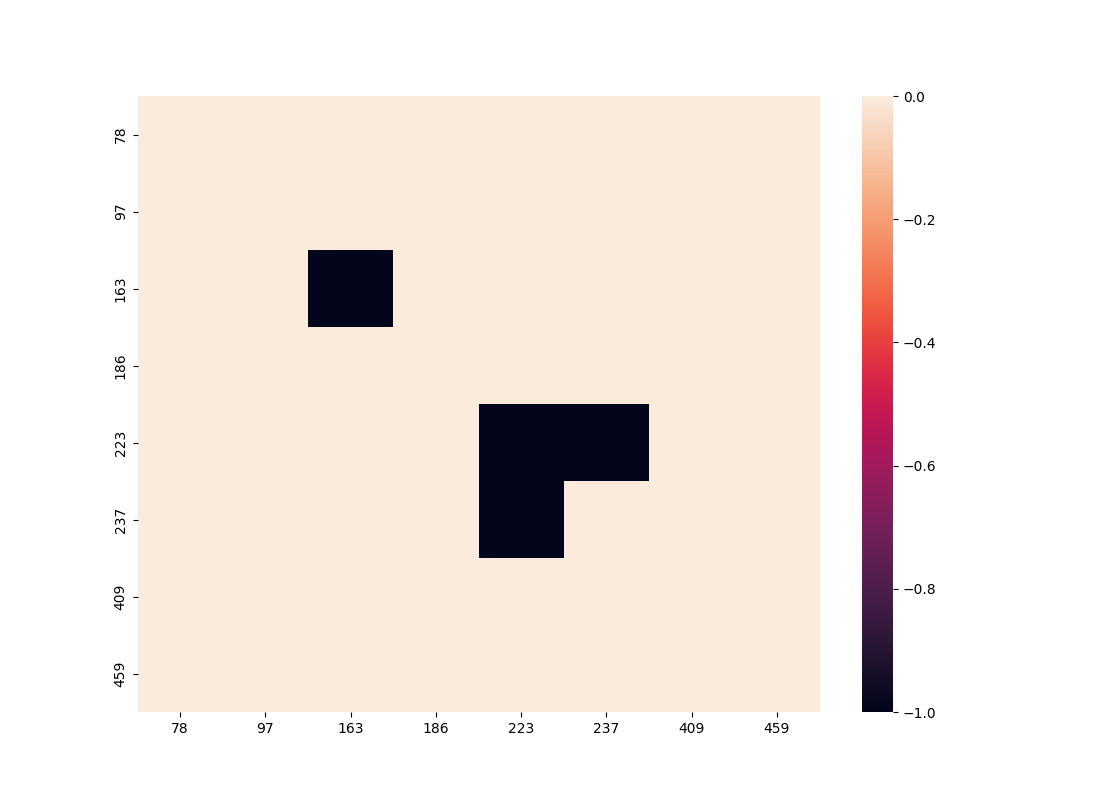

In [105]:
print(f'GT: {changepoints}')
print(f'checkpoints: {checkpoints}')
cor_mat = check_pts_mat(xa_new, x, y,
                        check_arange, ext_width=100)
print(cor_mat)
plt.figure(figsize = (11,8))
sns.heatmap(cor_mat, xticklabels=xa_new, yticklabels=xa_new)
plt.show()

In [170]:
###
#1,0,0,1 or 0,1,1,0 -> TP
###
check1 = 187
check2 = 138
print(f'GT: {changepoints}')
print('[1_l, 2_r], [1_r, 2_r], [1_l, 2_l], [1_r, 2_l]')
k = signal_comparison(x, y, np.arange(min(40, abs(check1-check2)), min(100, int(abs(check1-check2)*2)), 2), check1, check2)
print(k)
print("----------------------")
print(k.mean(axis=0))

GT: [  4  26  87  90 124 267 328 445]
[1_l, 2_r], [1_r, 2_r], [1_l, 2_l], [1_r, 2_l]


TypeError: signal_comparison() missing 1 required positional argument: 'checkpoint2'

In [ ]:
checkpoint = 215
val = []
val_check = []
ext_width = 100
checkpoint += ext_width

xs = x
ys = y
ww = win_widths1

for WINDOW_WIDTH in ww:  


    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
        
    xs = datas[0]
    ys = datas[1]
    print(xs[checkpoint], ys[checkpoint])
    xs = xs[checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
    ys = ys[checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]

    plt.figure()
    plt.plot(xs, ys, linewidth=0.8)
    plt.scatter(xs[int(WINDOW_WIDTH/2)], ys[int(WINDOW_WIDTH/2)], c='red')


        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

    xs1 = xs[1: int(len(xs)/2) + 1] - float(xs[1: int(len(xs)/2 + 1)][0])
    xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

    ys1 = ys[1: int(len(ys)/2) + 1] - float(ys[1: int(len(ys)/2) + 1][0])
    ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])
    
    xs1 = uncumulate(xs1)
    xs2 = uncumulate(xs2)
    ys1 = uncumulate(ys1)
    ys2 = uncumulate(ys2)

    std_xs1 = np.std(xs1)
    std_xs2 = np.std(xs2)
    std_ys1 = np.std(ys1)
    std_ys2 = np.std(ys2)

    surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
    surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
    surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
    surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH

    # here abs
    #xs1 = abs(np.sum(np.cumsum((xs1)))) #* surface_xs1
    #xs2 = abs(np.sum(np.cumsum((xs2)))) #* surface_xs2
    #ys1 = abs(np.sum(np.cumsum((ys1)))) #* surface_ys1
    #ys2 = abs(np.sum(np.cumsum((ys2)))) #* surface_ys2

    #print(xs1, xs2)
    #print("!!", ys1, ys2)
    xs1 = abs(np.cumsum((xs1))) #* surface_xs1
    xs2 = abs(np.cumsum((xs2))) #* surface_xs2
    ys1 = abs(np.cumsum((ys1))) #* surface_ys1
    ys2 = abs(np.cumsum((ys2))) #* surface_ys2
    #print("@@", ys1, ys2)
    xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
    xs1 = xs1 / xs_max_val
    xs2 = xs2 / xs_max_val
    #xs1 = xs1 / WINDOW_WIDTH
    #xs2 = xs2 / WINDOW_WIDTH

    ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
    #ys1 = ys1 / xs_max_val
    #ys2 = ys2 / xs_max_val
    ys1 = ys1 / ys_max_val
    ys2 = ys2 / ys_max_val
    #ys1 = ys1 / WINDOW_WIDTH 
    #ys2 = ys2 / WINDOW_WIDTH
    print(xs1.shape, xs2.shape, ys1.shape, ys2.shape)
    """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
    """

        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #val.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #val.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        
        #print(np.sum(xs1 - xs2), np.sum(ys1 - ys2), np.sum(xs1 - xs2) + np.sum(ys1 - ys2))
    val_check.append( (abs(xs1[-1] - (xs2[-1]) + (ys1[-1]) - (ys2[-1]))))
        
        #print(std_xs1, std_xs2, std_ys1, std_ys2)
        #val.append(abs(np.sum(xs1 - xs2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + np.sum(ys1 - ys2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2))))
        #val.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))

    #print('@@', abs(xs1 - xs2 + ys1 - ys2))
    #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) 
    #               * abs((max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
    #                     * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2))))

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        #val.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)

        #xs1 = xs1 / np.std(xs1)
        #xs2 = xs2 / np.std(xs2)
        #ys1 = ys1 / np.std(ys1)
        #ys2 = ys2 / np.std(ys2)

        #xs1 = np.cumsum(xs1)
        #xs2 = np.cumsum(xs2)
        #ys1 = np.cumsum(ys1)
        #ys2 = np.cumsum(ys2)
        #ys1 = abs(ys1)
        #ys2 = abs(ys2)

    """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
    """
    """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)

        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)

        print(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
                     + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
    """
        
    my_xs = np.concatenate((xs1, xs2))
    my_ys = np.concatenate((ys1, ys2))

    plt.figure()
    plt.plot(np.arange(WINDOW_WIDTH), my_xs, label=f'{(abs(xs1[-1] - (xs2[-1]) + (ys1[-1]) - (ys2[-1])))}' )
    plt.plot(np.arange(WINDOW_WIDTH), my_ys, label=f'{WINDOW_WIDTH}' )
    plt.legend()

plt.figure()
plt.plot(ww, val_check)
print(np.mean(val_check))